In [1]:
import os
os.environ['DEVELOPMENT'] = 'True'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement, GroundWater, FieldMngt
from aquacrop.utils import prepare_weather, get_filepath



INFO:root:Running the simulation in development mode.
c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop\lib\site-packages\aquacrop\solution\root_zone_water.py:4: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC
INFO:root:"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.

## Setup comparison function

In [2]:
# drop rows that contain repetitions of the headers throughout the file, one per successive annual run
def remove_headers(data):
    start_points=data[data.isin(['Day']).any(axis=1)].index # begin row drops where 'Day' is in any col
    end_points = [x+3 for x in start_points] # end 3 lines later
    to_drop=[]
    n=0

    while(n < len(start_points)):
        x=list(range(start_points[n]-1, end_points[n]-1)) # adjust drops, one line before the indexes found previously
        to_drop.extend(x) # add all indexes to drop to a list
        n=n+1

    new_data = data.drop(index=to_drop)

    return new_data

In [3]:
def extract_py_data(py_model):
    py_growth=py_model.get_crop_growth()
    py_wflux=py_model.get_water_flux()
    #py_wstorage=py_model.get_water_storage()

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')

    py_growth['datetime']=py_growth.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_wflux['datetime']=py_wflux.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)

    py_growth.drop(['dap','time_step_counter','season_counter'], inplace=True,axis=1)
    py_wflux.drop(['dap','time_step_counter','season_counter'], inplace=True,axis=1)

    py_outputs=pd.merge(py_growth, py_wflux, on='datetime')
    py_outputs['source']='AQ-Py'
    py_outputs.rename(columns={
            'yield_': 'dry_yield',
            # 'Month': 'month',
            # 'Day': 'day',
            },
            inplace=True, 
            errors='raise')

    return py_outputs

    

In [4]:
def extract_win_data(proj_name):

    file_list=['Crop','Wabal','Prof','Clim'] # ,'CompWC'
    data=[]

    for i in range(0,len(file_list)):
        file_type=file_list[i]
        path='C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+proj_name+file_type+'.OUT'
        if file_type=='Crop':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=33)
        elif file_type=='Wabal':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=27)
            temp=temp.drop(['Tr', 'Trx','Tr/Trx', 'WCTot','Rain'],axis=1)
        elif file_type=='Prof':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=19, index_col=False)
            temp=temp.drop(['Z'],axis=1)
        #elif file_type=='CompWC':
        #    temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=5, skipfooter=9)
        elif file_type=='Clim':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=15)
        
        #if file_type != 'CompWC':
        temp=temp.drop([0])
        
        temp.rename(columns={
            'Year': 'year',
            'Month': 'month',
            'Day': 'day',
            },
            inplace=True, 
            errors='raise'
        )
        temp=remove_headers(temp)
        # add datetime column
        temp['datetime'] = pd.to_datetime(temp[['year','month','day']])
        # convert all cols except date-related cols to floats
        cols=temp.columns.drop(['day','month','year','datetime'])
        temp[cols]=temp[cols].apply(pd.to_numeric, errors='coerce')
        temp=temp.drop(['year','month','day','DAP','Stage'], axis=1)
        data.append(temp)

    temp1=pd.merge(data[0],data[1], on='datetime')
    temp2=pd.merge(temp1,data[2], on='datetime')
    win_data=pd.merge(temp2,data[3], on='datetime')
    #win_data=pd.merge(temp3,data[4], on='datetime')   
    
    # rename cols to align with py col names
    win_data.rename(columns={'CC': 'canopy_cover',
                            'Y(dry)': 'dry_yield',
                            'Biomass': 'biomass',
                            'HI':'harvest_index',
                            'Z':'z_root',
                            },
                    inplace=True, errors='raise'
                    )
    win_data['harvest_index']=win_data['harvest_index']/100
    win_data['canopy_cover']=win_data['canopy_cover']/100
    win_data['biomass']=win_data['biomass']*100
    
    win_data['source']='AQ-Win'

    return win_data
    # Crop: daily crop growth: 4, 33

    # Wabal: daily water balance: 4,27

    # Prof: daily soil-water content in soil profile (WC) and root zone (Wr): 4,19

    # CompWC: daily soil-water content at various depths: 4,9

    # Clim: climate input data: 4,15

In [18]:
def run_comparison_v7(win_filename, py_model):

    # Get Python daily output
    py_daily_outputs = py_model.get_crop_growth()
    py_daily_outputs['biomass']=py_daily_outputs['biomass']/100
    py_daily_outputs['canopy_cover']=py_daily_outputs['canopy_cover']*100
    py_daily_outputs['dap']=py_daily_outputs['dap'].astype(int)

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')
    
    py_daily_outputs['datetime']=py_daily_outputs.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_daily_outputs['year']=pd.DatetimeIndex(py_daily_outputs['datetime']).year
    py_daily_outputs['month']=pd.DatetimeIndex(py_daily_outputs['datetime']).month
    py_daily_outputs['day']=pd.DatetimeIndex(py_daily_outputs['datetime']).day
    py_daily_outputs['source']='AQ-Py'

    # Get Python annual outputs
    py_annual_outputs = py_model._outputs.final_stats.round(3)
    #py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry-yield", "fresh-yield","yield-potential", "Seasonal irrigation (mm)"]
    py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry-yield", "Seasonal irrigation (mm)"]
    py_annual_outputs['source']='Py'


    # Get windows daily outputs
    win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
    win_daily_outputs=win_daily_outputs.drop([0])
    win_daily_outputs.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')

    win_daily_outputs=remove_headers(win_daily_outputs)
    # add datetime column
    win_daily_outputs['datetime'] = pd.to_datetime(win_daily_outputs[['year','month','day']])
    # convert all cols except date-related cols to floats
    win_daily_outputs['CC']=win_daily_outputs['CC'].astype(float)
    cols=win_daily_outputs.columns.drop(['day','month','year','datetime'])
    win_daily_outputs[cols]=win_daily_outputs[cols].apply(pd.to_numeric, errors='coerce')
    # rename cols to align with py col names
    win_daily_outputs.rename(columns={'CC': 'canopy_cover',
                                'Y(dry)': 'Yield',
                                'Biomass': 'biomass',
                                'HI':'harvest_index',
                                },
                    inplace=True, errors='raise')
    win_daily_outputs['harvest_index']=win_daily_outputs['harvest_index']/100
    win_daily_outputs['source']='AQ-Win'
    win_daily_outputs.to_csv('win-outputs.csv', index = False, encoding='utf-8')

    # Get windows annual outputs
    win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT', 
                                skiprows=4, skipfooter=8,  delim_whitespace=True,encoding="ISO-8859-1")
    win_annual_outputs=win_annual_outputs.drop([0])
    win_annual_outputs=remove_headers(win_annual_outputs)
    win_annual_outputs = win_annual_outputs.iloc[: , :-5] # remove 5 blank cols due to reading error
    win_annual_outputs['datetime']=pd.to_datetime(win_annual_outputs[['Year','Month','Day']])
    win_annual_outputs.columns=['Nr','Day','Month','Year','biomass','dry-yield','fresh-yield', 'datetime']
    win_annual_outputs=win_annual_outputs[win_annual_outputs['Nr'] != '0'] # remove blank rows
    win_annual_outputs['source']='Win'

    # Combine annual outputs
    combined_annual=pd.concat([win_annual_outputs, py_annual_outputs])
    combined_annual['dry-yield']=combined_annual['dry-yield'].astype(float)

    # Combine daily outputs
    both_daily_outputs=pd.concat([win_daily_outputs, py_daily_outputs])

    g1=sns.lineplot(data=both_daily_outputs, x='datetime',y='canopy_cover', hue='source')
    sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    #g.set_yticks(range(0,110,10), labels=range(0,110,10)) 
    g2=sns.lineplot(data=both_daily_outputs, x='datetime',y='biomass', hue='source')
    sns.move_legend(g2, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g2b=sns.lineplot(data=both_daily_outputs, x='datetime',y='harvest_index', hue='source')
    sns.move_legend(g2b, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g3=sns.lineplot(data=combined_annual.reset_index(), x='datetime', y='dry-yield', hue='source')
    sns.move_legend(g3, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    print(combined_annual.sort_values(['dry-yield']))
    
    all_daily_outputs=[py_model.get_crop_growth(), py_model.get_water_flux(), py_model.get_water_storage(), win_daily_outputs]

    return all_daily_outputs

# Exercise 7

## Exercise 7.1 with Tunis Local soil

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_17204\2506521418.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_17204\2506521418.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


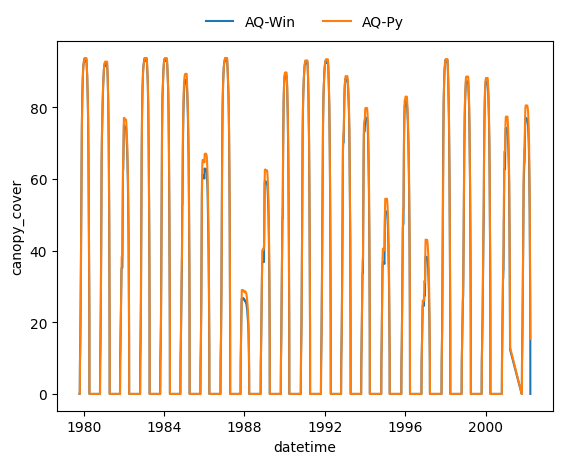

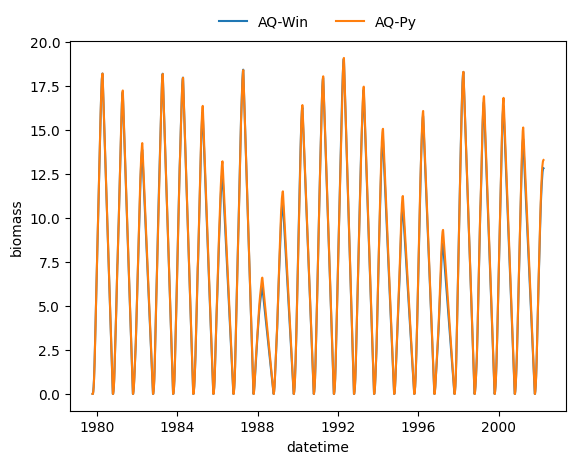

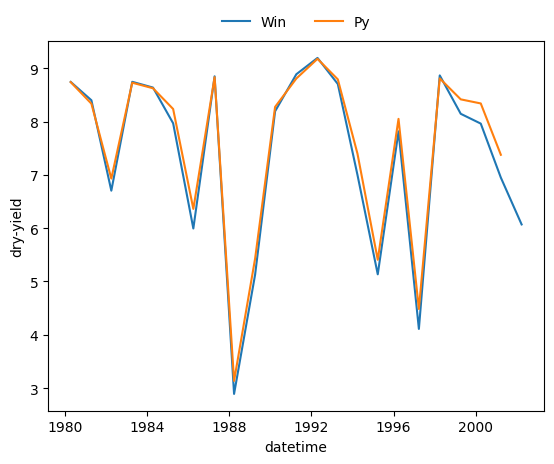

In [6]:
# Tunis climate
filepath=get_filepath('tunis_climate.txt')
weather_data = prepare_weather(filepath)

# Local Tunis soil
tunis_soil = Soil(soil_type='ac_TunisLocal')

# crops
wheat = Crop('WheatGDD', planting_date='10/15')

# IWC
wet_dry = InitialWaterContent(wc_type='Num',
                              method='Depth',
                              depth_layer=[0.3,0.9],
                              value=[0.3,0.15])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=weather_data,
                      soil=tunis_soil,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LocalSoil', model)

### Exercise 7.1 with Sandy Loam

In [7]:
# Sandy loam soil
sandy_loam = Soil(soil_type='SandyLoam')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_SLSoil', model)

KeyboardInterrupt: 

## Exercise 7.2 Local wheat variety

In [ ]:
# Local wheat variety
local_wheat=Crop('WheatLongGDD', planting_date= '10/15')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=local_wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LongVar', model)

## Exercise 7.3 Different initial conditions

WetDry

In [ ]:
model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_WetDry', model)

Field Capacity:

In [ ]:
# Change initial water content 
field_capacity = InitialWaterContent(value=['FC'])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=field_capacity,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_FC', model)

30% TAW

In [ ]:
# Change initial water content
iwc30taw = InitialWaterContent('Pct','Layer',[1],[30])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc30taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_30TAW', model)

75% TAW

In [ ]:
# Change initial water content
iwc75taw = InitialWaterContent('Pct','Layer',[1],[75])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc75taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_75TAW', model)

## Exercise 7.6 Net irrigation requirement

In [ ]:
net_irr = IrrigationManagement(irrigation_method=4,net_irr=78.26)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

## Exercise 7.7 Assess deficit irrigation schedules

In [ ]:
all_days=pd.date_range('1979/12/01', '2001/12/01',freq='12MS')

dates=[]

for each_start in all_days:
    app1=each_start
    app2=each_start+pd.Timedelta(30,'d')
    app3=each_start+pd.Timedelta(60,'d')
    dates.extend([app1,app2,app3])

n_years=len(all_days)
depths=[30,40,40]*n_years

schedule=pd.DataFrame([dates,depths]).T # create pandas DataFrame
schedule.columns=['Date','Depth'] # name columns

net_irr = IrrigationManagement(irrigation_method=5, Schedule=schedule)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

# Exercise 8

## Exercise 8.2 Paddy rice in Hyderabad planting dates

In [ ]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Hyderabad soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

# field management
bunds20 = FieldMngt(bunds=True, z_bund=0.20)

model = AquaCropModel(sim_start_time=f'{2000}/08/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_1Aug', model)

In [ ]:
# crop
local_rice = Crop('localpaddy', planting_date='07/15')

model = AquaCropModel(sim_start_time=f'{2000}/07/15',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_15Jul', model)

## Exercise 8.3 Initial conditions

Field capacity

In [ ]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Local Brussels soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_FC', model)

30% TAW

In [ ]:
# IWC
taw30 = InitialWaterContent('Pct','Layer',[1],[30])
model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=taw30,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_30TAW', model)

75% TAW

In [ ]:
# IWC
taw75 = InitialWaterContent('Pct','Layer',[1],[75])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      initial_water_content=taw75,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_75TAW', model)

Wet Top

In [ ]:
# IWC
wetTop = InitialWaterContent('Prop','Depth',[0.5,2],['FC','WP'])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      initial_water_content=wetTop,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_wetTop', model)

# Exercise 9

## Exercise 9.1 Potato in Brussels

In [6]:
# Brussels climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1987}/04/25', # 1976
                      sim_end_time=f'{1988}/12/31', # 2002
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

#daily_outputs = run_comparison_v7('Bru_Pot', model)

True

Get soil profile data from windows outputs

In [5]:
win_daily_outputs = extract_win_data('Bru_Pot')

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11020\896082959.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=33)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11020\896082959.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=27)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_11020\896082959.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=19, index_col=False)
C:

In [7]:
py_data=extract_py_data(py_model=model)

print(py_data.columns)

Index(['gdd', 'gdd_cum', 'z_root', 'canopy_cover', 'canopy_cover_ns',
       'biomass', 'biomass_ns', 'harvest_index', 'harvest_index_adj',
       'dry_yield', 'datetime', 'Wr', 'z_gw', 'surface_storage', 'IrrDay',
       'Infl', 'Runoff', 'DeepPerc', 'CR', 'GwIn', 'Es', 'EsPot', 'Tr',
       'TrPot', 'source'],
      dtype='object')


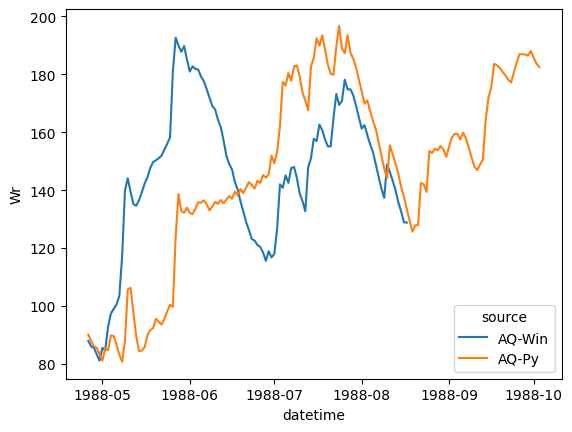

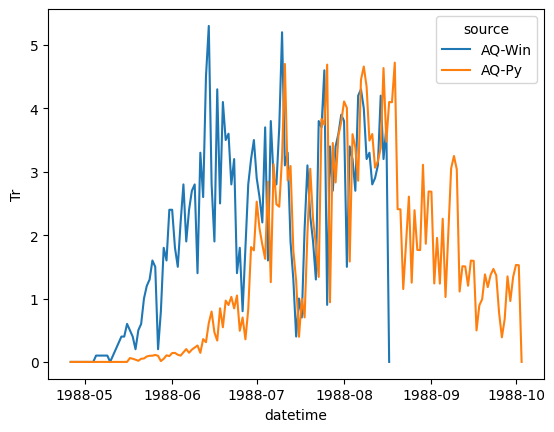

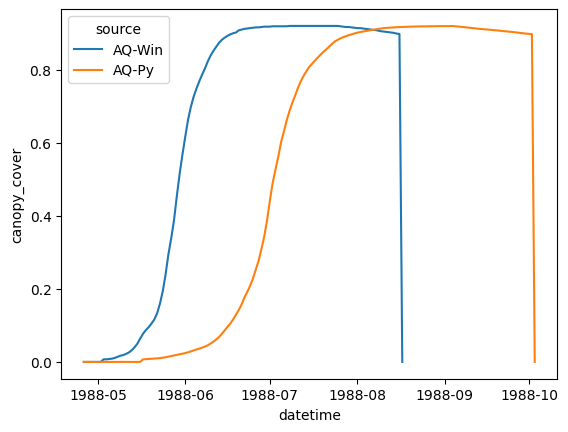

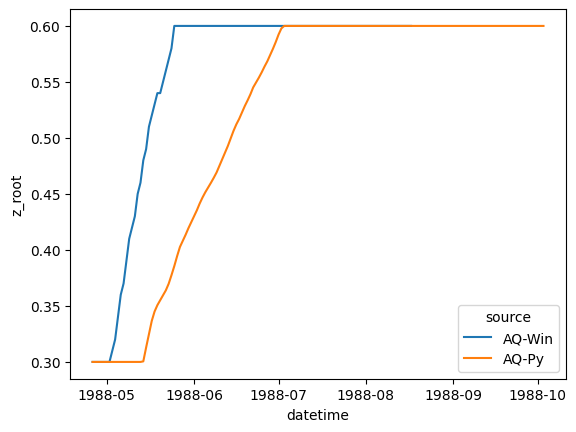

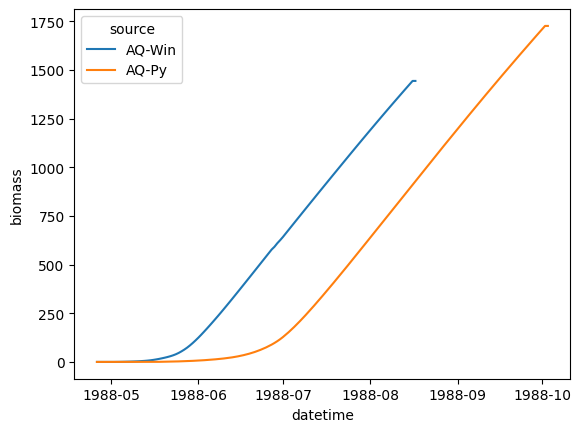

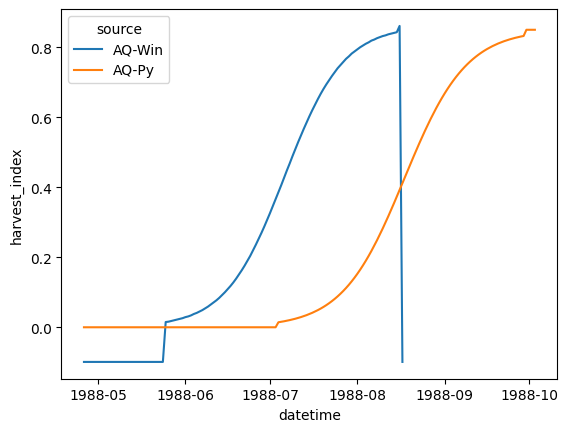

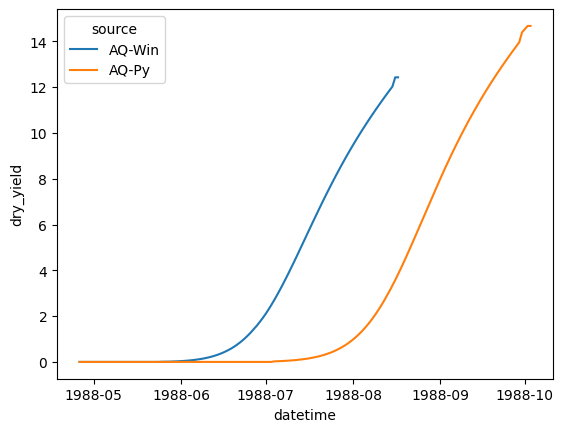

In [8]:
# py_growth=daily_outputs[0]
# py_wflux=daily_outputs[1]
# py_wstorage=daily_outputs[2]
# #win_outputs=daily_outputs[0]

# print(py_growth.columns)
# print(py_wflux.columns)
# print(py_wstorage.columns)

win_outputs_88=win_daily_outputs[(win_daily_outputs['datetime'] > '1988-04-25') & (win_daily_outputs['datetime'] < '1988-12-31')]
py_outputs_88=py_data[(py_data['datetime'] > '1988-04-25') & (py_data['datetime'] < '1988-12-31')]
# start_year,start_month,start_day='1987','04','25'
# py_wflux['datetime']=py_wflux.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
# py_wflux['source']='AQ-Py'




combined_87_88=pd.concat([win_outputs_88, py_outputs_88])

g1=sns.lineplot(data=combined_87_88, x='datetime',y='Wr', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='Tr', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='canopy_cover', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='z_root', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='biomass', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='harvest_index', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='dry_yield', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()


## 9.4 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_17204\2506521418.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_17204\2506521418.py:71: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


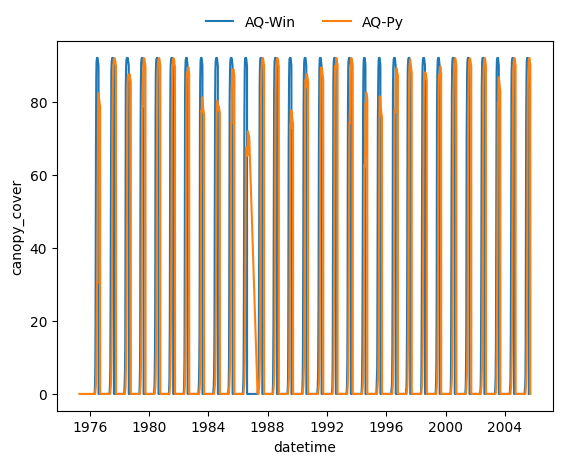

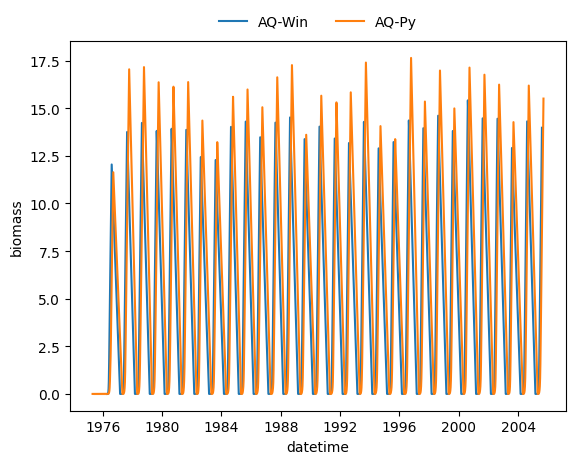

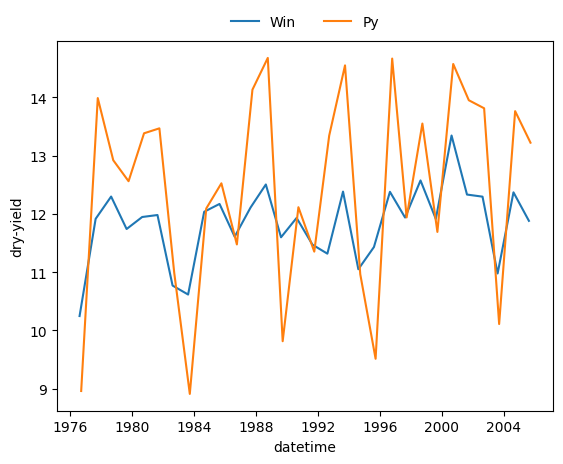

In [12]:
net_irr = IrrigationManagement(irrigation_method=4,NetIrrSMT=21)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=net_irr,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_NetIrr', model)

## 9.5 Generating irrigation schedules

In [ ]:
# function to return the irrigation depth to apply on next day
def get_depth(model, raw):    
    t = model._clock_struct.time_step_counter # current timestep
    if t>0 and model._init_cond.depletion/model._init_cond.taw > raw:
        depth=15
    else:
        depth=0

    return depth

36% RAW allowable depletion

In [ ]:
# Loamy sand soil
loamy_sand = Soil(soil_type='LoamySand')

# crop
potato = Crop('PotatoLocal', planting_date='04/25')

# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply
    depth=get_depth(model,0.36)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr36RAW', model)

100% RAW

In [ ]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply
    depth=get_depth(model,1)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr100RAW', model)

150% RAW

In [ ]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply
    depth=get_depth(model,1.5)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr150RAW', model)

## 9.6 Climate change impact

Historical:

In [ ]:
# Hist climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocal', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Historical', model)

Future:

In [ ]:
# Future climate
filepath=get_filepath('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/aquacrop/aquacrop/data/brussels_future.txt')
brussels_future = prepare_weather(filepath)

model = AquaCropModel(sim_start_time=f'{2021}/01/01',
                      sim_end_time=f'{2050}/12/31',
                      weather_df=brussels_future,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Future2', model)

In [ ]:
future_eto=pd.read_csv('../../AquaCrop-windows/AquaCropV7.1/DATA/Bru_Pot_Future2py.ETo')
future_temp=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/Bru_Pot_Future2py.Tnx')
future_precip=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/Bru_Pot_Future2py.PLU')

temp=future_eto.join(future_temp)
future_clim=temp.join(future_precip)
future_clim['datetime']=pd.date_range('2021/01/01','2050/12/31')
future_clim['Year']=pd.DatetimeIndex(future_clim['datetime']).year
future_clim['Month']=pd.DatetimeIndex(future_clim['datetime']).month
future_clim['Day']=pd.DatetimeIndex(future_clim['datetime']).day

future_clim.rename(columns={
    'Tmin (C)' : 'Tmin(C)',
    'TMax (C)' : 'Tmax(C)',
    'Average ETo (mm/day)' : 'Et0(mm)',
    'Total Rain (mm)' : 'Prcp(mm)'
},
inplace=True    
)

future_clim.drop('datetime',axis=1,inplace=True)
col_order=['Day', 'Month','Year','Tmin(C)','Tmax(C)','Prcp(mm)','Et0(mm)']
future_clim=future_clim[col_order]

future_clim.to_csv('brussels_future.txt', sep='\t')
%pwd
print(future_clim)


In [ ]:
pwd